# Computation of transverse-Ising jump operators

In [1]:
include("notebook_preamble.jl");

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
┌ Info: Precompiling Arpack [7d9fca2a-8960-54d3-9f78-7d1dccf2cb97]
└ @ Base loading.jl:1278
┌ Info: Precompiling QuantumOptics [6e0679c1-51ea-5a7c-ac74-d61b76210b0c]
└ @ Base loading.jl:1278
┌ Info: Precompiling PGFPlots [3b7a836e-365b-5785-a47d-02c71176b4aa]
└ @ Base loading.jl:1278


In [2]:
using BenchmarkTools, Revise
includet("TransverseIsingModels.jl")
using .TransverseIsingModels
TIM = TransverseIsingModels;

Setup

In [3]:
title(s::TransverseIsingModel{N}) where N = latexstring("$(N)-spin transverse Ising model with \$\\lambda =\$ $(s.λ)");

In [4]:
# These can likely be made more efficient.
opip(A, B) = tr(dagger(A) * B)
opip(A) = tr(dagger(A) * A)
opnorm(A) = √opip(A)
opnormalize(A) = A / opnorm(A)
opcos(A, B) = real(abs(opip(A, B)) / (opnorm(A) * opnorm(B)))

project(P, J) = opip(P / opip(P), J)
# project(P, J) = J == zero(J) ? missing : opip(P / opip(P), J)
jumpcos(P, J) = opcos(P, J);
# jumpcos(P, J) = J == zero(J) ? missing : opcos(P, J);

Jump operator computations

In [5]:
using Statistics

In [6]:
function J(s, A, P, ΔEs, Πs)
    project(P, jumpoperator(ΔEs, A, Πs))
end
function jumpcomputation(s, bes)
    Πs, ωs = jumpinfo(s; basiseigensys=bes)
    _jumpcomputation(s, bes, Πs, ωs)
end;

In [7]:
_op(s, sa, i, bes) = changebasis(sa(s, i)::typeof(one(Tbasis(s))); basiseigensys=bes)
function _jumpcomputation(s, bes, Πs, ωs)
    sum(values(ωs)) do ΔEs
        all([sx, sy, sz]) do sa
            all([sx, sy, sz]) do sb
                all(0:(s.N-1)) do j
                    Js = Iterators.dropwhile(ismissing, (J(s, _op(s, sa, i, bes), _op(s, sb, ((i+j-1) % s.N) + 1, bes), ΔEs, Πs) for i in 1:s.N))
                    if isempty(Js)
                        true
                    else
                        J1, restJs = Iterators.peel(Js)
                        all(restJs) do Ji
                            ismissing(Ji) || TIM.isapprox.(J1, Ji, atol=1e-12)::Bool
                        end
                    end
                end
            end
        end
    end
end;

In [59]:
function find_projections(s, bes, Πs, ωs)
    As = interactions(s; basiseigensys=bes) |> collect
    Ps = sitejumps(s; basiseigensys=bes) |> collect
    Pnorm2s = map(opip, Ps)
    projections = map(values(ωs)) do ΔEs
        Js = map(As) do A
            jumpoperator(ΔEs, A, Πs)
        end
        Js = filter(x -> !iszero(x), Js)
        map(Iterators.product(Js, zip(Ps, Pnorm2s))) do (J, (P, Pn))
            opip(P, J) / Pn |> abs
        end
    end
    Iterators.flatten(projections) |> collect
end;

In [74]:
sproj = find_projections(tim, bes, Πs, ωs);

In [86]:
length(filter(x -> x > 0.01, sproj) |> collect) / length(sproj)

0.04687208216619981

In [64]:
gr()

Plots.GRBackend()

In [71]:
histogram(sproj, normalize=true,
    xlim=(-0.01, 0.05),
    xlabel=L"Projection magnitude $\abs{\ip{\hat{\opr{P}}}{\opr{J}}}$",
    ylabel="Density",
    title=title(tim),
    legend=false)
projkde = kde(sproj)
plot!(projkde.x, projkde.density)
vline!([1 / 2^tim.N])

GKS: glyph missing from current font: 73
GKS: glyph missing from current font: 108
\abs{\ip{\hat{\opr{P}}}{\opr{J}}}$: undefined symbol
GKS: glyph missing from current font: 73
GKS: glyph missing from current font: 108
\abs{\ip{\hat{\opr{P}}}{\opr{J}}}$: undefined symbol
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
\abs{\ip{\hat{\opr{P}}}{\opr{J}}}$: undefined symbol
\abs{\ip{\hat{\opr{P}}}{\opr{J}}}$: undefined symbol
GKS: glyph missing from current font: 73
GKS: glyph missing from current font: 108
GKS: glyph missing from current font: 73
GKS: glyph missing from current font: 108
GKS: glyph missing from current font: 73
GKS: glyph missing from current font: 108


In [9]:
njumps(tim) = jumpinfo(tim, basiseigensys=basiseigen(tim))[2] |> length;

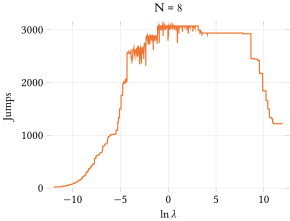

In [776]:
N = 8
λs = -12:0.01:12
plot(λ -> njumps(TransverseIsingModel(N, exp(λ))), λs, xlabel=L"\ln\lambda", ylabel="Jumps", key=false, title="N = $N")

In [10]:
function timviolin!(p, N, m)
    λ = exp(m)
    tim = TransverseIsingModel(N, λ)
    bes = basiseigen(tim)
    As = [changebasis(op(tim, i); basiseigensys=bes)
        for i in 1:tim.N, op in [sx, sy, sz]]
    Ps = [changebasis(op(tim, i); basiseigensys=bes)
        for i in 1:tim.N, op in [sx, sy, sz]]
    Πs, ωs = jumpinfo(tim; basiseigensys=bes)
    ωprojections = find_projections(tim, bes, Πs, ωs)
    violin!(p, repeat([m], length(ωprojections)), ωprojections,
        ylim=(-0.1 / 2^N, 2.0 / 2^N)
    )
end;

In [11]:
using StatsPlots

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1278


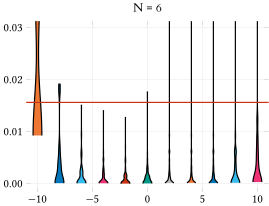

In [780]:
N = 6
p = plot(key=false, title="N = $N");
for m in (-10):2:10
    timviolin!(p, N, m)
end
hline!(p, [1 / 2^N])

Note that some values above $2^{-N}$ are cut off to show more detail.

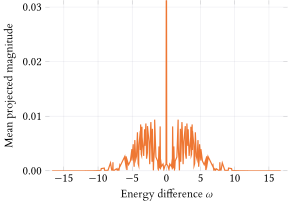

In [631]:
plot(ωprojections,
    xlabel=L"Energy difference $\omega$",
    ylabel="Mean projected magnitude",
    ylim=(0, 1 / 2^tim.N),
    key=false)

In [12]:
using KernelDensity

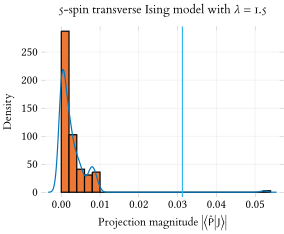

In [642]:
proj = collect(values(ωprojections))
histogram(proj, normalize=true,
    xlabel=L"Projection magnitude $\abs{\ip{\hat{\opr{P}}}{\opr{J}}}$",
    ylabel="Density",
    title=title(tim),
    legend=false)
projkde = kde(proj)
plot!(projkde.x, projkde.density)
vline!([1 / 2^tim.N])

### For fermions

In [38]:
function fermions(s::TIM.SpinSystem{N}; basiseigensys) where N
    (changebasis(op(s, m); basiseigensys=basiseigensys)
        for m in 1:N, op in [TIM.η, TIM.ηt])
end;

In [39]:
function fermion_projections(s, bes, Πs, ωs)
    As = fermions(s; basiseigensys=bes) |> collect
    Ps = sitejumps(s; basiseigensys=bes) |> collect
    Pnorm2s = map(opip, Ps)
#     projections = dictmap(ωs) do ΔEs
    projections = map(values(ωs)) do ΔEs
        Js = map(As) do A
            jumpoperator(ΔEs, A, Πs)
        end
        Js = filter(x -> !iszero(x), Js)
        map(Iterators.product(Js, zip(Ps, Pnorm2s))) do (J, (P, Pn))
            opip(P, J) / Pn |> abs
        end |> mean
    end
    projections = filter(v -> !isnan(v), projections)
end;

In [40]:
tim = TransverseIsingModel(5, 0.5)
bes = basiseigen(tim)
Πs, ωs = jumpinfo(tim; basiseigensys=bes);

In [48]:
ηprojections = fermion_projections(tim, bes, Πs, ωs);

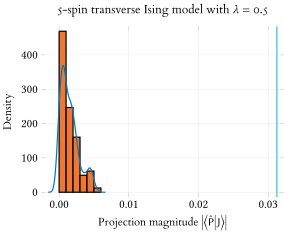

In [50]:
ηproj = collect(values(ηprojections))
histogram(ηproj, normalize=true,
    xlabel=L"Projection magnitude $\abs{\ip{\hat{\opr{P}}}{\opr{J}}}$",
    ylabel="Density",
    title=title(tim),
    legend=false)
ηprojkde = kde(ηproj)
plot!(ηprojkde.x, ηprojkde.density)
vline!([1 / 2^tim.N])

**TODO**
- Fix slowness: projections (maybe also from precompilation and type-instability).
- Check with the $\opr{\eta}_k$?